# Support Vector Machine (SVM) — Churn Prediction

This notebook trains a **Support Vector Machine (SVM)** classifier on the bank customer churn dataset.

We handle **imbalanced data** using `class_weight='balanced'` and optimize **F1-score** using grid search.  
Evaluation is performed using **confusion matrix** and **PR-AUC**


In [13]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import GridSearchCV


## Load Preprocessed Data

We assume that preprocessing has already been done, and the following CSVs exist in `data/processed`:

- `X_train_scaled.csv`
- `X_test_scaled.csv`
- `y_train.csv`
- `y_test.csv`


In [14]:
# Relative path from notebooks/models/03d_svm.ipynb to data/processed
processed_dir = Path('../../data/processed')

print("Looking for CSV files in:", processed_dir.resolve())

# Load CSVs
X_train = pd.read_csv(processed_dir / 'X_train_scaled.csv')
X_test  = pd.read_csv(processed_dir / 'X_test_scaled.csv')
y_train = pd.read_csv(processed_dir / 'y_train.csv')['churn']
y_test  = pd.read_csv(processed_dir / 'y_test.csv')['churn']

print("Data loaded successfully!")
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Looking for CSV files in: C:\Users\senki\CustomerChurn\data\processed
Data loaded successfully!
Shapes:
X_train: (8000, 15)
X_test:  (2000, 15)
y_train: (8000,)
y_test: (2000,)


## Define SVM Model and Grid Search

We use an **RBF kernel** and perform grid search over **C** and **gamma** to maximize **F1-score** for the minority class.


In [15]:
# Define SVM with balanced class weights
svc = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Hyperparameter grid
param_grid = {
    'C': [0.1, 1, 5, 10, 50],
    'gamma': [0.0001, 0.001, 0.01, 0.1]
}

# GridSearchCV for F1-score
grid = GridSearchCV(svc, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters found:", grid.best_params_)

# Train final SVM with best parameters
svm_final = grid.best_estimator_


Best parameters found: {'C': 5, 'gamma': 0.01}


## Hyperparameter F1-score Heatmap

We visualize the mean F1-score from GridSearchCV for all combinations of **C** and **gamma**.


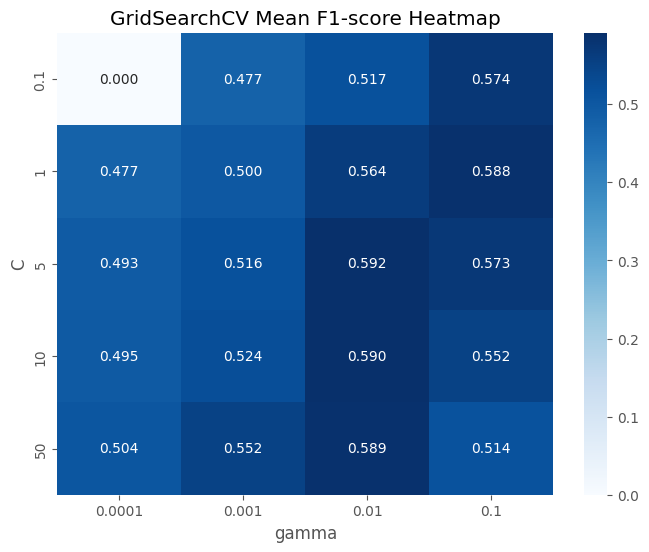

In [16]:
# Extract results
results = grid.cv_results_
mean_f1 = results['mean_test_score']
params = results['params']

# Unique C and gamma values
C_values = sorted(list(set([p['C'] for p in params])))
gamma_values = sorted(list(set([p['gamma'] for p in params])))

# Create heatmap array
heatmap_data = np.zeros((len(C_values), len(gamma_values)))

for i, C in enumerate(C_values):
    for j, gamma in enumerate(gamma_values):
        idx = [k for k, p in enumerate(params) if p['C']==C and p['gamma']==gamma][0]
        heatmap_data[i, j] = mean_f1[idx]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", xticklabels=gamma_values, yticklabels=C_values, cmap='Blues')
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('GridSearchCV Mean F1-score Heatmap')
plt.show()


## Predictions on Test Set


In [17]:
# Predictions
y_pred = svm_final.predict(X_test)
y_proba = svm_final.predict_proba(X_test)[:, 1]


## Evaluation Metrics


In [18]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-PR
pr_auc = average_precision_score(y_test, y_proba)
print("Test PR AUC:", pr_auc)


Confusion Matrix:
[[1289  304]
 [ 100  307]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1593
           1       0.50      0.75      0.60       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.73      2000
weighted avg       0.84      0.80      0.81      2000

Test PR AUC: 0.687919158624663


## PR Curve


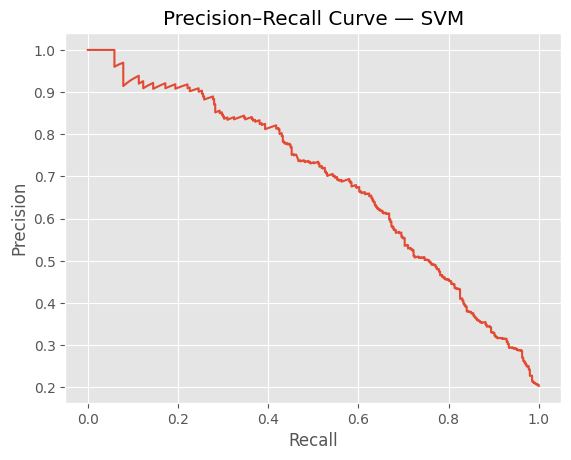

In [19]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — SVM")
plt.show()


## Save model predictions

Predictions and predicted probabilities on the test set are saved
for downstream analysis and comparison with other models.


In [20]:
results_svm = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred': y_pred,
    'y_proba': y_proba
})

results_svm.to_csv(
    '../../data/processed/svm_results.csv',
    index=False
)


## Summary

- SVM trained on **scaled features**
- Hyperparameters **C** and **gamma** selected using **F1-score**
- Confusion matrix and PR-AUC evaluate performance on the **imbalanced churn dataset**
- F1-score heatmap provides insight into **best hyperparameters**
